# **STEP 1: PROBLEM DESCRIPTION & DATASET**
This project is based on the Kaggle competition [Natural Language Processing with Disaster Tweets](https://www.kaggle.com/c/nlp-getting-started/overview), a binary text classification challenge that aims to determine whether a given tweet refers to an actual disaster. In real-life disaster response scenarios, this task has high practical significance, as it enables rapid classification of large volumes of real-time social media data, potentially assisting response teams in directing resources more effectively. The dataset includes a train.csv file with around 7,600 tweets, each labeled as either disaster-related (1) or not (0), with features such as a unique ID, the tweet’s content, keyword, and location. Additionally, an unlabeled test.csv file is provided for final evaluation. Results from applying our model to the test set are submitted to the Kaggle competition for scoring. Given its structured nature and balanced classes, this dataset is well-suited for classification models that can capture textual patterns and uncover linguistic nuances present in tweets.

In [ ]:
# Import necessary libraries
import gdown
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from google.colab import files
import re
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import BatchNormalization

# **STEP 2: EXPLORATORY DATA ANALYSIS (EDA)**
In our EDA, we first import the train and test files stored on Google Drive. After briefly inspecting the first few rows of the training set and reviewing the data types, we check for any missing values. We find that approximately one-third of the location values are missing, as well as about 60 keyword values. We will fill all of these missing values with the keyword ‘unknown’.

Next, we analyze the dataset through the following visualizations:
<br><br>
**Target Distribution Visualization:** It’s important to check the balance between the two classes in the dataset. The bar chart reveals that there are more non-disaster (0) tweets than disaster (1) ones, but the counts in each class are relatively high. While the data is slightly imbalanced, it remains sufficient for our analysis.

**Top Keywords in Disaster-Related Tweets:** We examine the frequency of keywords, noting that “unknown” is the most common. This finding highlights potential noise in this feature.

**Word Count Distribution:** A histogram illustrates that most tweets fall within the 10-20 word range, exhibiting a fairly normal distribution of word counts.

**Word Cloud for Each Class:** This visualization showcases the frequency of words in each class, with size and color indicating their prevalence. Some tokens consist of single characters or abbreviations, which are common in tweets but introduce challenges in processing against standard language rules.
<br><br>
Our cleaning steps include removing URLs and punctuation, as well as converting text to lowercase. We also remove common English stopwords to focus on more significant words that provide context to the tweet’s message.

Based on our EDA, we plan to implement basic NLP preprocessing techniques, such as splitting our training data into train and validation sets and tokenizing the training tweets for use in our models.


In [ ]:
# Use the Google Drive link to download the training set
file_id_train = '18etOscSZyWz6TlUrSGkmZrtPOc2Ok_Xe'
download_url_train = f"https://drive.google.com/uc?id={file_id_train}"

# Use the Google Drive link to download the testing set
file_id_test = '1xA93vTkP3Ce_6xQe3kQ2oYNoL_Pm3M8F'
download_url_test = f"https://drive.google.com/uc?id={file_id_test}"

# Download the training dataset
gdown.download(download_url_train, 'nlp_train.csv', quiet=False)

# Download the training dataset
gdown.download(download_url_test, 'nlp_test.csv', quiet=False)

# Load the training and testing dataset
train_data = pd.read_csv('nlp_train.csv')
test_data = pd.read_csv('nlp_test.csv')

Downloading...
From: https://drive.google.com/uc?id=18etOscSZyWz6TlUrSGkmZrtPOc2Ok_Xe
To: /content/nlp_train.csv
100%|██████████| 988k/988k [00:00<00:00, 149MB/s]
Downloading...
From: https://drive.google.com/uc?id=1xA93vTkP3Ce_6xQe3kQ2oYNoL_Pm3M8F
To: /content/nlp_test.csv
100%|██████████| 421k/421k [00:00<00:00, 109MB/s]


In [ ]:
# Inspect the dataset structure and check for null values
print(train_data.head())
print(train_data.info())

   id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target  
0       1  
1       1  
2       1  
3       1  
4       1  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB
None


In [ ]:
# Check for missing values
print(train_data.isnull().sum())

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64


In [ ]:
# Reassign the column after filling missing values
train_data['keyword'] = train_data['keyword'].fillna("unknown")
train_data['location'] = train_data['location'].fillna("unknown")

# Verify that there are no missing values left
print(train_data.isnull().sum())

id          0
keyword     0
location    0
text        0
target      0
dtype: int64


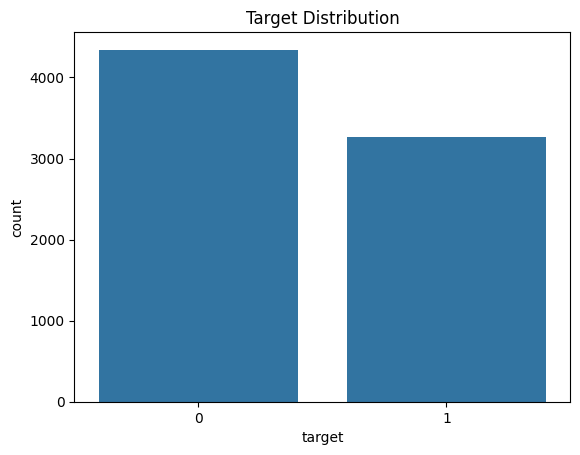

In [ ]:
#Plot of class distribution
sns.countplot(data=train_data, x='target')
plt.title('Target Distribution')
plt.show()

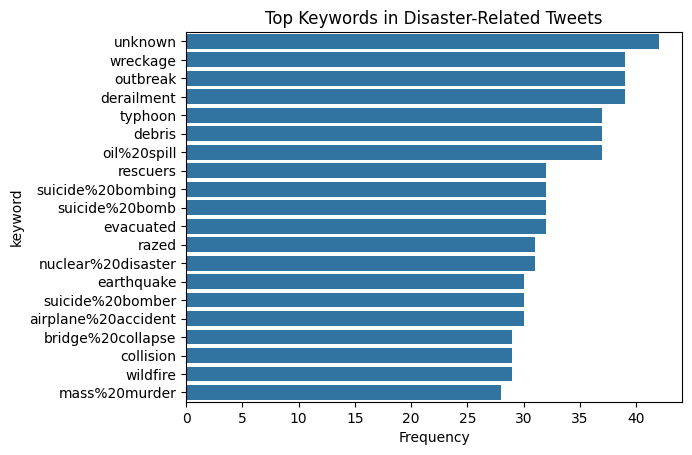

In [ ]:
# Plot of top disaster-related keywords
disaster_keywords = train_data[train_data['target'] == 1]['keyword'].value_counts().head(20)
sns.barplot(y=disaster_keywords.index, x=disaster_keywords.values)
plt.title('Top Keywords in Disaster-Related Tweets')
plt.xlabel('Frequency')
plt.show()

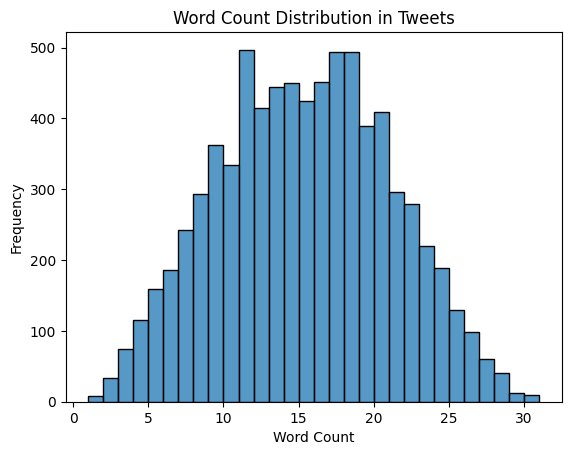

In [ ]:
# Plot of word count distribution
train_data['word_count'] = train_data['text'].apply(lambda x: len(x.split()))
sns.histplot(train_data['word_count'], bins=30)
plt.title('Word Count Distribution in Tweets')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.show()

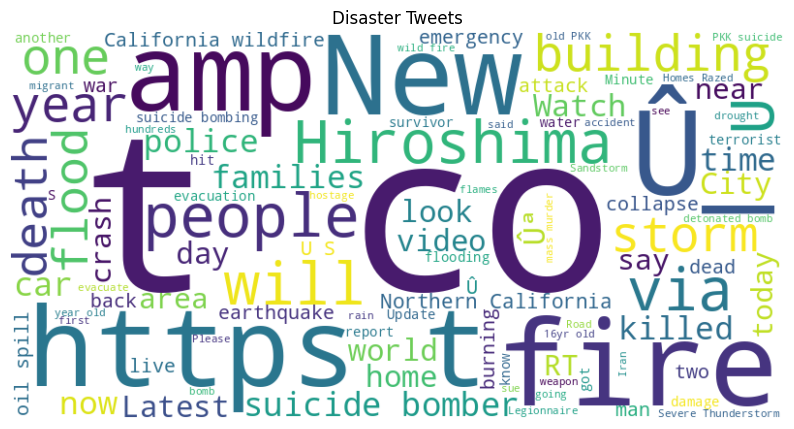

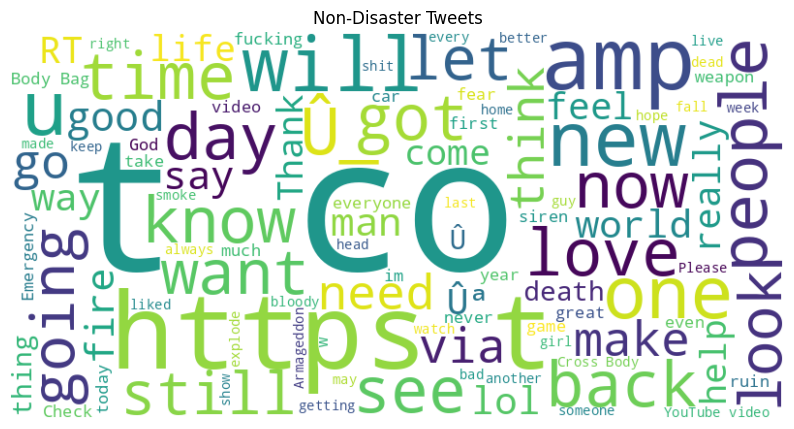

In [ ]:
#Word Cloud for each class
disaster_tweets = train_data[train_data['target'] == 1]['text']
non_disaster_tweets = train_data[train_data['target'] == 0]['text']

def plot_wordcloud(text, title):
    wordcloud = WordCloud(width=800, height=400, max_words=100, background_color='white').generate(" ".join(text))
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title)
    plt.axis('off')
    plt.show()

plot_wordcloud(disaster_tweets, 'Disaster Tweets')
plot_wordcloud(non_disaster_tweets, 'Non-Disaster Tweets')

In [ ]:
#Text cleaning
nltk.download('stopwords')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)
    text = re.sub(r'\@w+|\#', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = text.lower()
    text = " ".join([word for word in text.split() if word not in STOPWORDS])
    return text

train_data['cleaned_text'] = train_data['text'].apply(clean_text)
test_data['cleaned_text'] = test_data['text'].apply(clean_text)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# **STEP 3: MODEL ARCHITECTURE**
For this problem, we have decided to use a sequential neural network with LSTM (Long Short-Term Memory) layers. LSTMs are particularly well-suited for capturing patterns in sequential text data, as they can retain information across longer stretches of text. This ability makes them ideal for situations where the sequence of words can significantly affect their meaning.

After tokenizing the tweets, we set a maximum number of words and a maximum sequence length to ensure consistency in the input presented to our model. Longer tweets are truncated, while shorter ones are padded to maintain uniformity.

Our model consists of the following layers:
<br><br>
**Embedding Layer:** This layer transforms integer-encoded words into dense vectors of fixed size. Each word in the vocabulary is mapped to a 64-dimensional vector, allowing the model to grasp semantic relationships between words in the dataset.

**Bidirectional LSTM Layers:** These layers process the input data in both forward and backward directions, capturing dependencies across the sequence. The first LSTM layer returns the full sequence for further processing, while the second LSTM layer returns only the last output, which encapsulates more abstract information about each input.

**Dropout Layers:** Two dropout layers are included—one after the first LSTM layer and another after the Dense layer. These layers help reduce overfitting by randomly setting 50% of the input units to zero at each update, preventing the model from becoming overly reliant on specific features.

**Dense Layer:** This layer contains 32 neurons and utilizes the Rectified Linear Unit (ReLU) activation function. It processes information from the previous LSTM layer, allowing the model to learn complex relationships among the extracted features.

**Output Layer:** The final layer employs a sigmoid activation function to determine the probability of an input tweet belonging to either of our two classes. This is a standard choice for binary classification problems like ours.
<br><br>
The model is compiled using the Adam optimizer and binary cross-entropy as the loss function, and we evaluate its performance based on both training and validation accuracy.


In [ ]:
# Tokenization and padding
MAX_NUM_WORDS = 10000
MAX_SEQ_LENGTH = 100

tokenizer = Tokenizer(num_words=MAX_NUM_WORDS, oov_token="<OOV>")
tokenizer.fit_on_texts(train_data['cleaned_text'])

X_train = tokenizer.texts_to_sequences(train_data['cleaned_text'])
X_train = pad_sequences(X_train, maxlen=MAX_SEQ_LENGTH, padding='post')

y_train = train_data['target'].values

In [ ]:
# Splitting the data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [ ]:
# Create model
embedding_dim = 64
model = Sequential([
    Embedding(MAX_NUM_WORDS, embedding_dim), #input_length=MAX_SEQ_LENGTH),
    Bidirectional(LSTM(64, return_sequences=True)),
    Dropout(0.5),
    Bidirectional(LSTM(32)),
    Dense(32, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train the Model
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=32, callbacks=[early_stopping])

Epoch 1/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 17s 28ms/step - accuracy: 0.6087 - loss: 0.6464 - val_accuracy: 0.7833 - val_loss: 0.4661
Epoch 2/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.8676 - loss: 0.3543 - val_accuracy: 0.7814 - val_loss: 0.4965
Epoch 3/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.9253 - loss: 0.2303 - val_accuracy: 0.7702 - val_loss: 0.5600
Epoch 4/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.9513 - loss: 0.1702 - val_accuracy: 0.7597 - val_loss: 0.6623


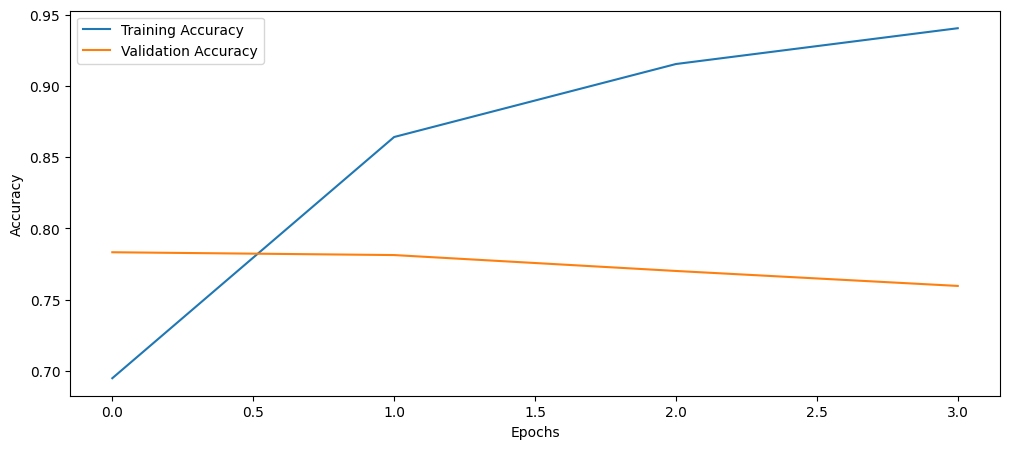

In [ ]:
# Step 5: Evaluate the Model
# 1. Visualize training performance
plt.figure(figsize=(12, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
# 2. Validation set evaluation
val_predictions = (model.predict(X_val) > 0.5).astype(int).flatten()
print("Validation Accuracy:", accuracy_score(y_val, val_predictions))
print(classification_report(y_val, val_predictions))

48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
Validation Accuracy: 0.783322390019698
              precision    recall  f1-score   support

           0       0.79      0.84      0.82       874
           1       0.77      0.70      0.73       649

    accuracy                           0.78      1523
   macro avg       0.78      0.77      0.78      1523
weighted avg       0.78      0.78      0.78      1523



In [ ]:
# Step 6: Prepare Submission
# Process the test data the same way as training data
X_test = tokenizer.texts_to_sequences(test_data['cleaned_text'])
X_test = pad_sequences(X_test, maxlen=MAX_SEQ_LENGTH, padding='post')

# Predict on test data
test_predictions = (model.predict(X_test) > 0.5).astype(int).flatten()

# Create submission file
submission = pd.DataFrame({'id': test_data['id'], 'target': test_predictions})
submission.to_csv('nlp_submission.csv', index=False)
print("Submission file saved as submission.csv")

102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
Submission file saved as submission.csv


In [ ]:
# Download submission file
files.download('nlp_submission.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

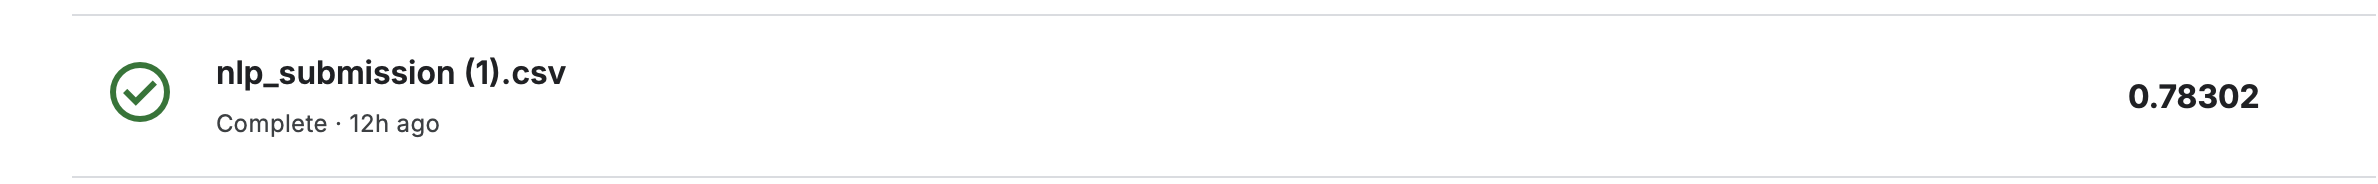

# **STEP 4: RESULTS AND ANALYSIS**
Our initial model was set to train for 10 epochs, but due to increasing validation loss with each epoch, Early Stopping triggered, limiting training to only 4 epochs. While training accuracy was high at 95.13%, validation accuracy showed a steady decline from an initial peak of 78.33% to 75.97% by the final epoch. This discrepancy suggests that the model may be overfitting to the training data, resulting in reduced generalizability to unseen data.

The initial model produced the following results on the validation set:
<br><br>
**Accuracy:** 78.33%

**Precision:** 0.79 for non-disaster tweets (class 0), 0.77 for disaster tweets (class 1)

**Recall:** 0.84 for class 0, 0.70 for class 1

**F1-Score:** 0.82 for class 0, 0.73 for class 1
<br><br>
These metrics, along with the initial Kaggle score of 0.78302, indicate moderate generalization. However, the trends suggest room for improvement, especially in reducing overfitting and boosting accuracy on disaster-related tweets.

To enhance performance, we implemented an optimized architecture that incorporated pre-trained GloVe embeddings and several regularization techniques. Key modifications and their intended impacts include:
<br><br>
**Pre-trained GloVe Embeddings:** We initialized our embedding layer with 100-dimensional GloVe embeddings, providing a richer vocabulary representation compared to random initialization. This aimed to improve the model’s grasp of semantic relationships within tweets.

**LSTM Layers with L2 Regularization:** L2 regularization was added to the LSTM layers to help mitigate overfitting.

**Batch Normalization:** Batch normalization layers after each LSTM stabilized training and minimized sensitivity to input scale changes.

**Dropout Layers:** Dropout was applied at different points, with a slightly reduced rate of 0.3 (down from 0.5 in the initial model), allowing the model to retain useful features while still preventing overfitting.

**Dense Layer with L2 Regularization:** L2 regularization in the Dense layer helped the model capture complex relationships without overfitting.

**Learning Rate Scheduling:** An exponentially decaying learning rate, starting at 0.0005, allowed for more gradual convergence.

**Class Weights Adjustment:** Class weights were adjusted to emphasize disaster tweets (class 1), which were underrepresented in the dataset.

**Increased Batch Size:** A larger batch size of 64 helped improve generalization by averaging gradients over a broader sample.
<br><br>
The optimized model trained for 13 epochs, with a gradual increase in training accuracy that did not reach the high levels seen in the initial model. Validation accuracy improved slightly at first and then leveled off, with training halted due to stagnation in validation loss.

Final results on the validation set for the optimized model were:
<br><br>
**Validation Accuracy:** 81.09%

**Precision:** 0.81 for both non-disaster and disaster tweets

**Recall:** 0.88 for non-disaster (class 0), 0.72 for disaster (class 1)

**F1-Score:** 0.84 for class 0, 0.76 for class 1
<br><br>
With a Kaggle score of 0.80324, the optimized model achieved moderate improvement over the initial model, reflecting enhanced stability and a reduction in overfitting. This improved architecture demonstrates better balance and generalizability, particularly in classifying disaster tweets more accurately.


In [ ]:
# Use the Google Drive link to download GloVe embeddings
file_id_glove_100d = '1LGWn9A9GBzStD53vHdLJ0183i3yXwSEb'
download_url_glove_100d = f"https://drive.google.com/uc?id={file_id_glove_100d}"

# Download the training dataset
gdown.download(download_url_glove_100d, 'glove.6B.100d.txt', quiet=False)

# Step 1: Loading GloVe embeddings
embedding_index = {}
with open('glove.6B.100d.txt', 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coefs

# Create the embedding matrix
embedding_dim = 100
word_index = tokenizer.word_index
embedding_matrix = np.zeros((MAX_NUM_WORDS, embedding_dim))
for word, i in word_index.items():
    if i < MAX_NUM_WORDS:
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

Downloading...
From (original): https://drive.google.com/uc?id=1LGWn9A9GBzStD53vHdLJ0183i3yXwSEb
From (redirected): https://drive.google.com/uc?id=1LGWn9A9GBzStD53vHdLJ0183i3yXwSEb&confirm=t&uuid=b8efe58d-67f2-4944-8641-a458d5f16073
To: /content/glove.6B.100d.txt
100%|██████████| 347M/347M [00:08<00:00, 39.4MB/s]


In [ ]:
# Step 2: Modify Model Architecture
model = Sequential([
    Embedding(MAX_NUM_WORDS, embedding_dim, input_length=MAX_SEQ_LENGTH,
              weights=[embedding_matrix], trainable=True),  # Start with trainable=False
    Bidirectional(LSTM(64, return_sequences=True, kernel_regularizer=l2(0.001))),
    BatchNormalization(),
    Dropout(0.3),  # Reduced dropout
    Bidirectional(LSTM(32, kernel_regularizer=l2(0.001))),
    BatchNormalization(),
    Dropout(0.5),  # Reduced dropout
    Dense(32, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

# Step 3: Adjust Learning Rate Scheduler
initial_learning_rate = 0.0005  # Smaller initial learning rate
lr_schedule = ExponentialDecay(
    initial_learning_rate=initial_learning_rate,
    decay_steps=10000,
    decay_rate=0.95
)
optimizer = Adam(learning_rate=lr_schedule)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)              │ ?                           │       1,000,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_8 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_9 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,000,000 (3.81 MB)

 Trainable params: 1,000,000 (3.81 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Step 4: Early Stopping with a Reduced Patience Value
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Define class weights
class_weights = {0: 1.0, 1: 1.5}

# Step 5: Training with Increased Batch Size
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=64,  # Increased batch size
    class_weight=class_weights,
    callbacks=[early_stopping]
)

Epoch 1/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - accuracy: 0.4926 - loss: 1.6789 - val_accuracy: 0.7295 - val_loss: 1.1884
Epoch 2/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.6497 - loss: 1.3264 - val_accuracy: 0.7754 - val_loss: 1.0583
Epoch 3/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.7180 - loss: 1.1741 - val_accuracy: 0.7531 - val_loss: 0.9979
Epoch 4/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.7556 - loss: 1.0952 - val_accuracy: 0.8004 - val_loss: 0.9175
Epoch 5/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.7802 - loss: 1.0357 - val_accuracy: 0.8116 - val_loss: 0.8889
Epoch 6/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.8133 - loss: 0.9610 - val_accuracy: 0.8148 - val_loss: 0.8552
Epoch 7/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.8132 - loss: 0.9327 - val_accuracy: 0.7997 - val_loss: 0.8499
Epoch 8/20
96/96 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.8350 - loss: 0.8726 - val_accuracy: 0.8155 - v

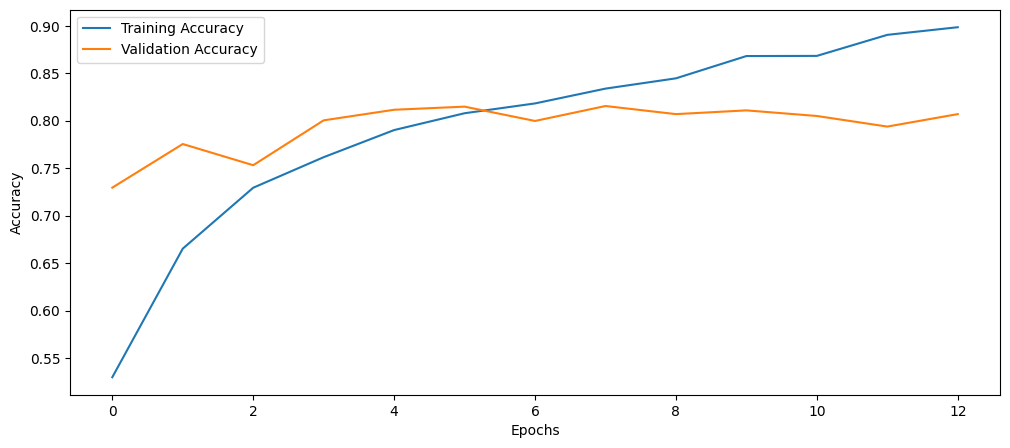

In [ ]:
# Step 6: Evaluate the Model
plt.figure(figsize=(12, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
# Validation evaluation
val_predictions = (model.predict(X_val) > 0.5).astype(int).flatten()
print("Validation Accuracy:", accuracy_score(y_val, val_predictions))
print(classification_report(y_val, val_predictions))

48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
Validation Accuracy: 0.8108995403808273
              precision    recall  f1-score   support

           0       0.81      0.88      0.84       874
           1       0.81      0.72      0.76       649

    accuracy                           0.81      1523
   macro avg       0.81      0.80      0.80      1523
weighted avg       0.81      0.81      0.81      1523



In [ ]:
# Save submission
X_test = tokenizer.texts_to_sequences(test_data['cleaned_text'])
X_test = pad_sequences(X_test, maxlen=MAX_SEQ_LENGTH, padding='post')
test_predictions = (model.predict(X_test) > 0.5).astype(int).flatten()
submission = pd.DataFrame({'id': test_data['id'], 'target': test_predictions})
submission.to_csv('optimized_submission.csv', index=False)
print("Submission file saved as submission.csv")

102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
Submission file saved as submission.csv


In [ ]:
# Download submission file
files.download('optimized_submission.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

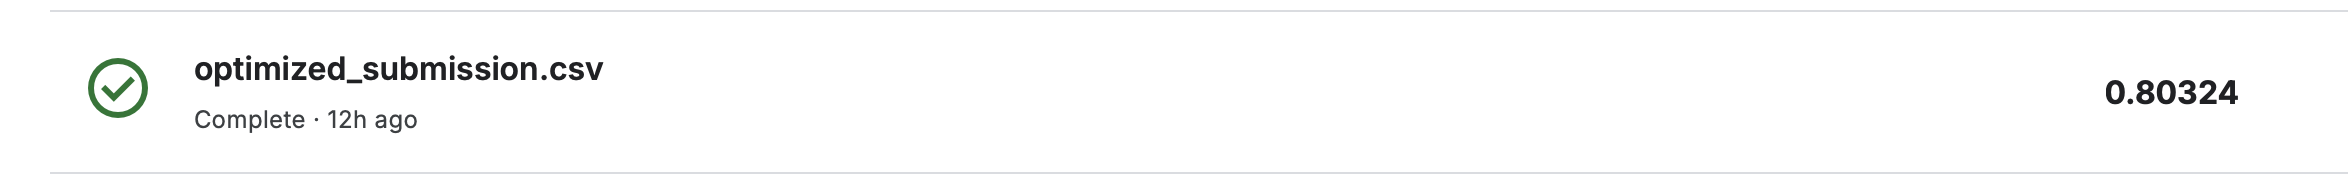

# **STEP 5: CONCLUSION**
Classifying disaster tweets has provided valuable insights into the capabilities of deep learning, specifically through an LSTM-based architecture. Our initial model demonstrated solid performance on the test set; however, signs of overfitting indicated a need for better generalization to new data.

To address this, we enhanced the model by integrating GloVe embeddings, applying learning rate adjustments, tuning batch sizes, and adding batch normalization and regularization. These changes contributed to a more stable model with slight improvements in validation set performance, though the increase in our Kaggle score was modest. This suggests that simpler configurations may be sufficient for balanced datasets of this size.

Looking forward, future improvements could focus on further hyperparameter tuning, experimenting with architectural adjustments, or exploring transformer-based models such as BERT or RoBERTa, which have been pre-trained on vast datasets and might better capture complex relationships within tweets. These enhancements would add to the model’s ability to understand tweet nuances, improving its real-world applicability in disaster response scenarios.
